In [65]:
from dptb.nnops.trainer import Trainer
from dptb.data import ABACUSInMemoryDataset
from dptb.data.transforms import OrbitalMapper
from dptb.nn import build_model

from dptb.plugins.monitor import TrainLossMonitor, LearningRateMonitor
from dptb.plugins.train_logger import Logger
from dptb.plugins.plugins import Saver
import heapq
import logging
from dptb.utils.loggers import set_log_handles

common_options = {
    "basis": {
        "Ga": "2s2p2d1f",
        "N": "2s2p1d"
    },
    # "basis":{"Mo":"3s2p2d", "S":"2s2p1d"},
    "device": "cuda:0",
    "dtype": "float32",
    "overlap": False,
}

root = "/share/semicond/lmp_abacus/abacus_hse_data/GaN/prod-gan/GaN/sys-000/processed_GaN_pbe"
train_dataset = ABACUSInMemoryDataset(
    root=root,
    preprocess_dir="/share/semicond/lmp_abacus/abacus_hse_data/GaN/prod-gan/GaN/sys-000/processed_GaN_pbe",
    AtomicData_options={
        "r_max": 8.0,
        "er_max": None,
        "oer_max": None,
        "pbc": True,
    },
    type_mapper=OrbitalMapper(basis=common_options["basis"]),
)

train_options = {
    "seed": 12070,
    "num_epoch": 4000,
    "batch_size": 1,
    "optimizer": {
        "lr": 0.01,
        "type": "Adam",
    },
    "lr_scheduler": {
        "type": "exp",
        "gamma": 0.9995
    },
    "loss_options":{
        "train":{"method": "eigvals"}
    },
    "save_freq": 10,
    "validation_freq": 10,
    "display_freq": 1
}

run_opt = {
        "init_model": "/root/e3/local/local_ni_sij/checkpoint/dptb.ep278.pth",
        "restart": None,
        "freeze": False,
        "train_soc": False,
        "log_path": None,
        "log_level": None
    }

model_option = {
    "embedding":{
            "method": "e3baseline",
            "r_max": 7.0,
            "irreps_hidden": "68x0e+68x1o+32x1e+32x2e+16x2o+16x3o+8x3e+8x4e+8x5o",
            "lmax": 4,
            "n_layers": 3,
            "n_radial_basis": 100,
            "env_embed_multiplicity": 50,
            "avg_num_neighbors": 63
        },
        "prediction":{
            "method": "e3tb",
            "scales_trainable":True,
            "shifts_trainable":True
        }
}

model = build_model(run_opt, {}, common_options)

trainer = Trainer(
    train_options = train_options,
    common_options = common_options,
    model = model,
    train_datasets = train_dataset,
)

trainer.register_plugin(Saver([(10, 'iteration'), (1, 'epoch')]), checkpoint_path="./")
trainer.register_plugin(TrainLossMonitor())
# trainer.register_plugin(Validationer())
trainer.register_plugin(LearningRateMonitor())
trainer.register_plugin(Logger(["train_loss", "lr"], 
    interval=[(1, 'iteration'), (1, 'epoch')]))
set_log_handles(getattr(logging, "INFO"))
for q in trainer.plugin_queues.values():
    heapq.heapify(q)

/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [2]:
model.eval()

DPTB(
  (embedding): E3BaseLineModelLocal(
    (sh): SphericalHarmonics()
    (onehot): OneHotAtomEncoding()
    (init_layer): InitLayer(
      (two_body_latent): ScalarMLPFunction(
        (_forward): RecursiveScriptModule(original_name=GraphModule)
      )
      (_env_weighter): Linear(1x0e+1x1o+1x2e+1x3o+1x4e -> 1x0e+1x1o+1x2e+1x3o+1x4e | 5 weights)
      (env_embed_mlp): ScalarMLPFunction(
        (_forward): RecursiveScriptModule(original_name=GraphModule)
      )
      (bessel): BesselBasis()
    )
    (layers): ModuleList(
      (0): Layer(
        (_env_weighter): Linear(1x0e+1x1o+1x2e+1x3o+1x4e -> 1x0e+1x1o+1x2e+1x3o+1x4e | 5 weights)
        (env_linears): Identity()
        (lin_pre): Linear(1x0e+1x1o+1x2e+1x3o+1x4e -> 1x0e+1x1o+1x2e+1x3o+1x4e | 5 weights)
        (activation): Gate (142x0e+32x1o+16x2e+16x3o+8x4e+4x5o+2x6e -> 64x0e+32x1o+16x2e+16x3o+8x4e+4x5o+2x6e)
        (tp): SeparateWeightTensorProduct(
          (tp): TensorProduct(1x0e+1x1o+1x2e+1x3o+1x4e x 1x0e+1x1o+1

In [64]:
model.edge_prediction_h.has_shifts

False

In [36]:
from dptb.data import AtomicData

dN = 100
ref_data = AtomicData.to_AtomicDataDict(train_dataset[dN].to("cuda:0"))
data = model(ref_data)

In [39]:
from dptb.nnops.loss import HamilLossAnalysis

ana = HamilLossAnalysis(idp=model.idp, device=model.device, decompose=True)

ana_result = ana(data, ref_data)

rmse err for bond N-N: 0.006236156914383173 	 mae err for bond N-N: 0.0025950458366423845
rmse err for bond N-Ga: 0.006706676445901394 	 mae err for bond N-Ga: 0.003527402877807617
rmse err for bond Ga-N: 0.0076290033757686615 	 mae err for bond Ga-N: 0.00350630609318614
rmse err for bond Ga-Ga: 0.01597902737557888 	 mae err for bond Ga-Ga: 0.006551219150424004
rmse err for atom N: 0.07213789969682693 	 mae err for bond N: 0.01558066438883543
rmse err for atom Ga: 0.11864019930362701 	 mae err for bond Ga: 0.01351923681795597


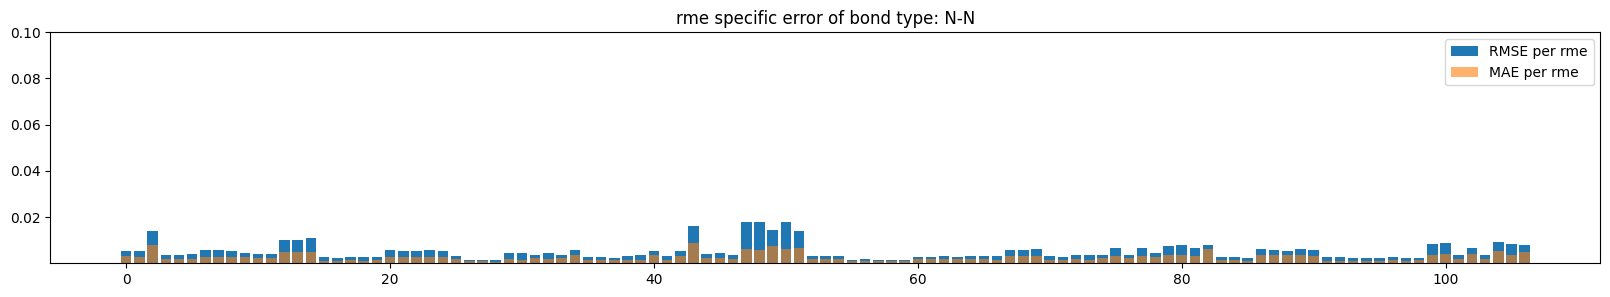

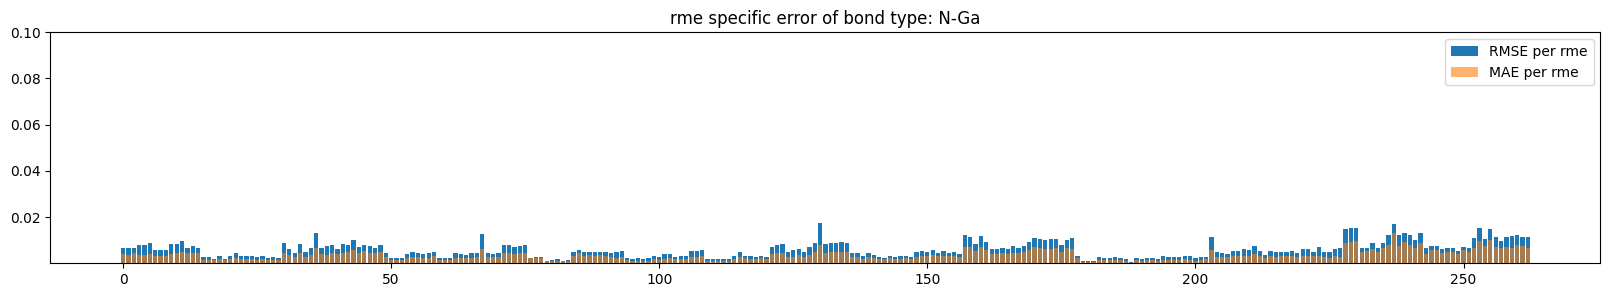

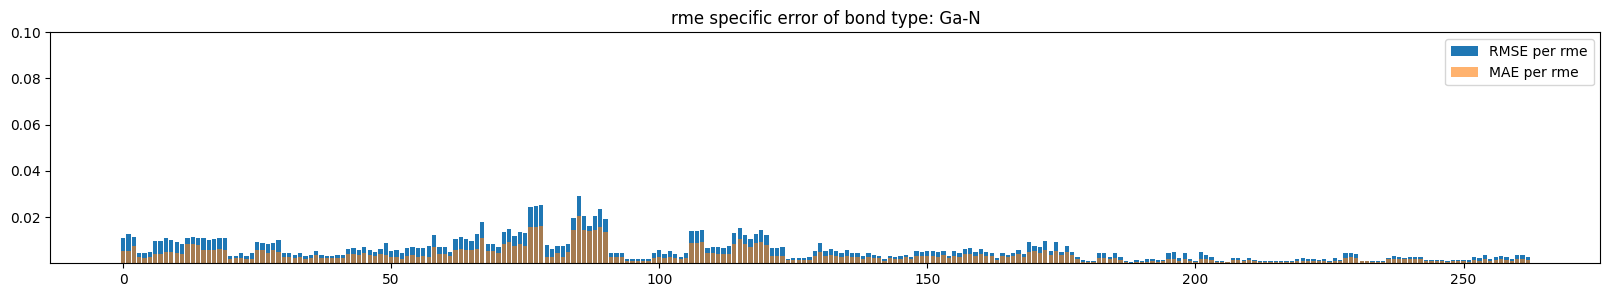

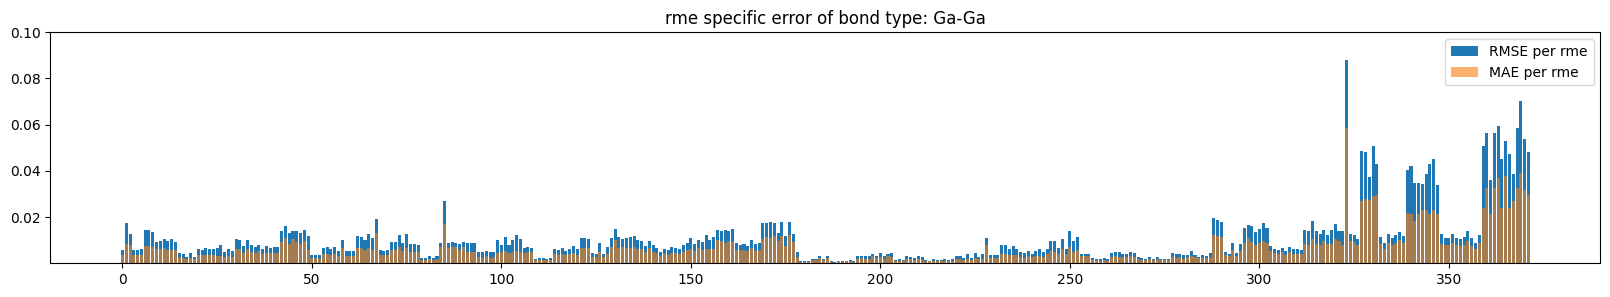

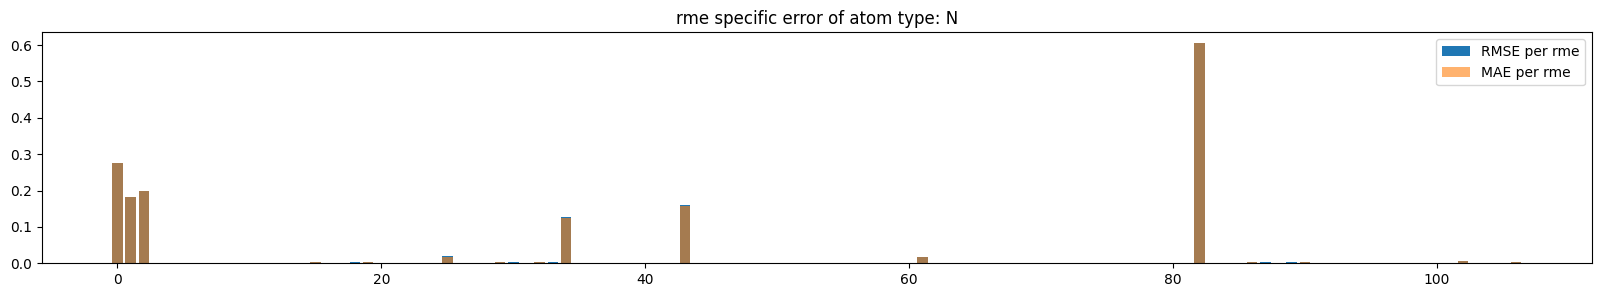

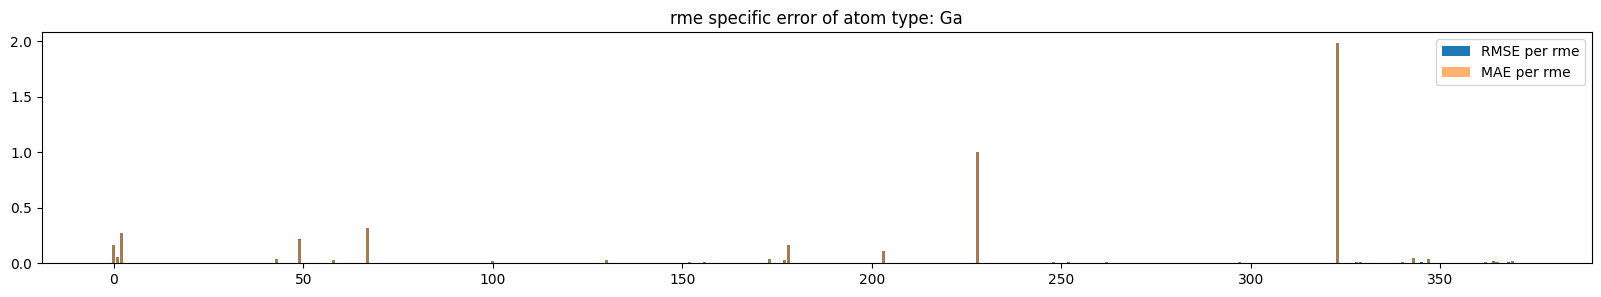

In [40]:
import matplotlib.pyplot as plt

for bt, err in ana_result["hopping"].items():
    print("rmse err for bond {bt}: {rmserr} \t mae err for bond {bt}: {maerr}".format(bt=bt, rmserr=err["rmse"], maerr=err["mae"]))

for bt, err in ana_result["onsite"].items():
    print("rmse err for atom {bt}: {rmserr} \t mae err for bond {bt}: {maerr}".format(bt=bt, rmserr=err["rmse"], maerr=err["mae"]))

for bt, err in ana_result["hopping"].items():
    x = list(range(len(err["rmse_per_block_element"])))
    rmserr = err["rmse_per_block_element"]
    maerr = err["mae_per_block_element"]

    plt.figure(figsize=(20,3))
    plt.bar(x, rmserr.cpu().detach(), label="RMSE per rme")
    plt.bar(x, maerr.cpu().detach(), alpha=0.6, label="MAE per rme")
    plt.legend()
    # plt.yscale("log")
    plt.ylim([1e-5, 1e-1])
    plt.title("rme specific error of bond type: {bt}".format(bt=bt))
    plt.show()

for at, err in ana_result["onsite"].items():
    x = list(range(len(err["rmse_per_block_element"])))
    rmserr = err["rmse_per_block_element"]
    maerr = err["mae_per_block_element"]

    plt.figure(figsize=(20,3))
    plt.bar(x, rmserr.cpu().detach(), label="RMSE per rme")
    plt.bar(x, maerr.cpu().detach(), alpha=0.6, label="MAE per rme")
    plt.legend()
    # plt.yscale("log")
    # plt.ylim([1e-5, 1e-1])
    plt.title("rme specific error of atom type: {at}".format(at=at))
    plt.show()

normalized MAE: 0.01137518510222435
absolute MAE: 0.003152984892949462
normalized RMSE: 0.021837739273905754
absolute RMSE: 0.005624402314424515
rmse err for bond N-N: 0.004660679027438164 	 mae err for bond N-N: 0.0025748249609023333
rmse err for bond N-Ga: 0.004921845160424709 	 mae err for bond N-Ga: 0.0031926194205880165
rmse err for bond Ga-N: 0.003325575264170766 	 mae err for bond Ga-N: 0.0020600969437509775
rmse err for bond Ga-Ga: 0.009528432041406631 	 mae err for bond Ga-Ga: 0.004762966651469469


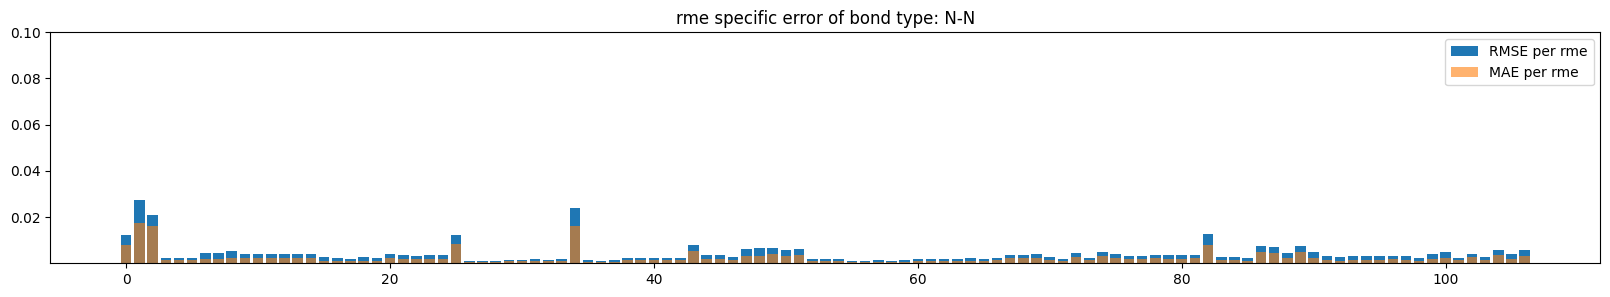

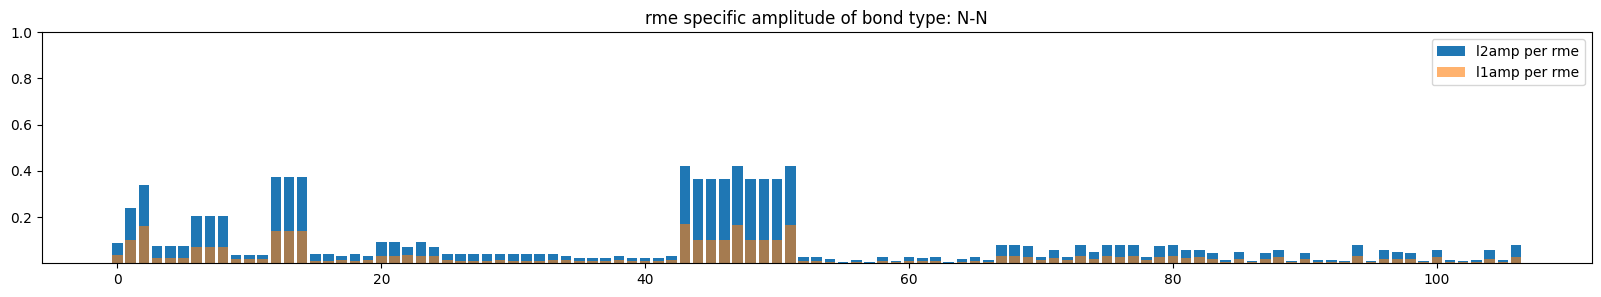

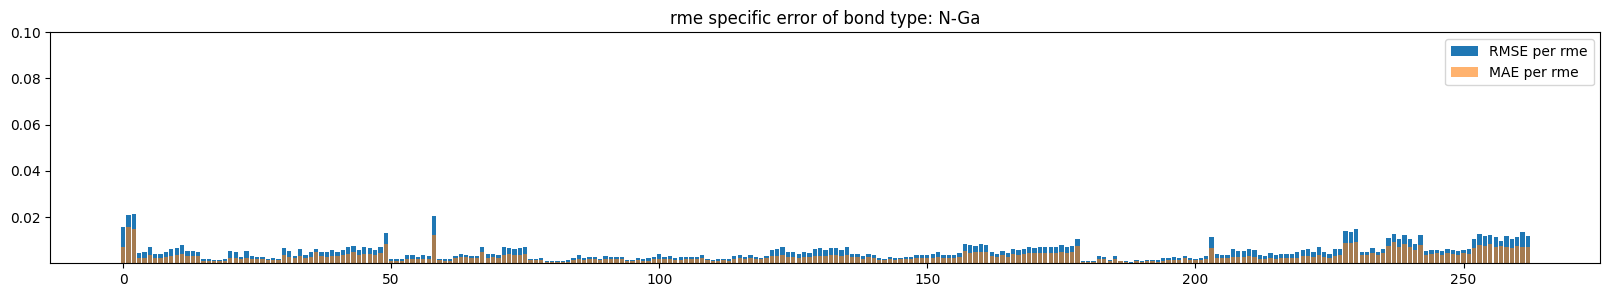

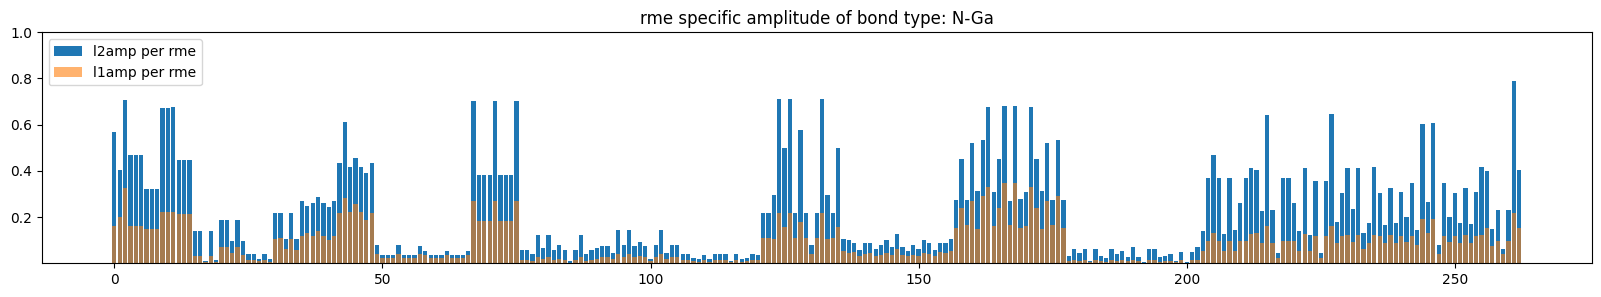

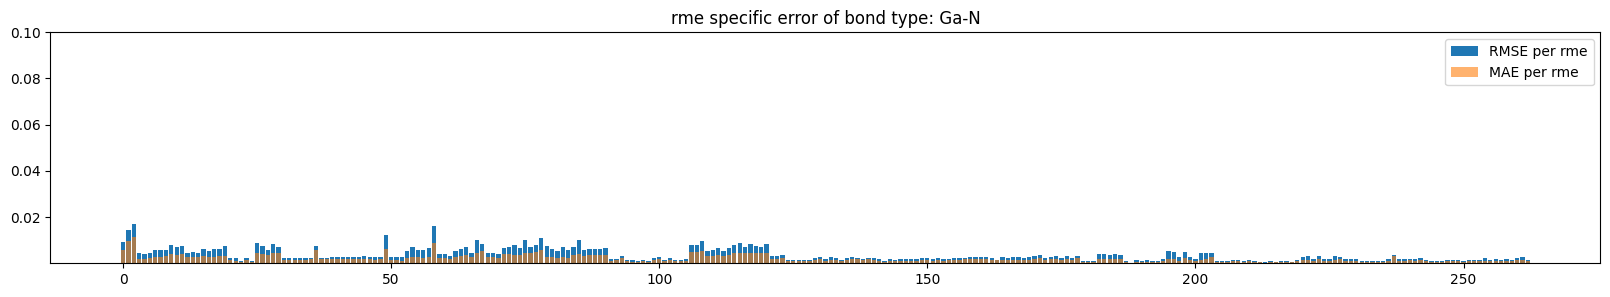

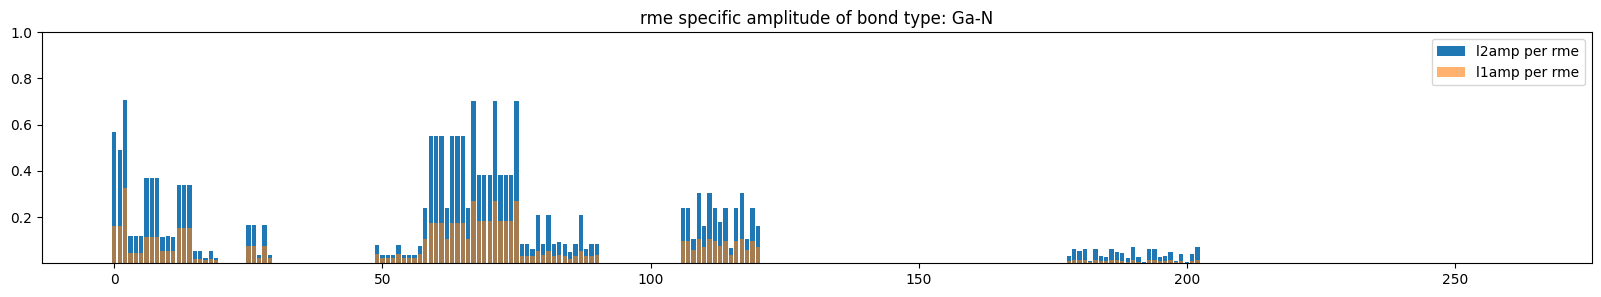

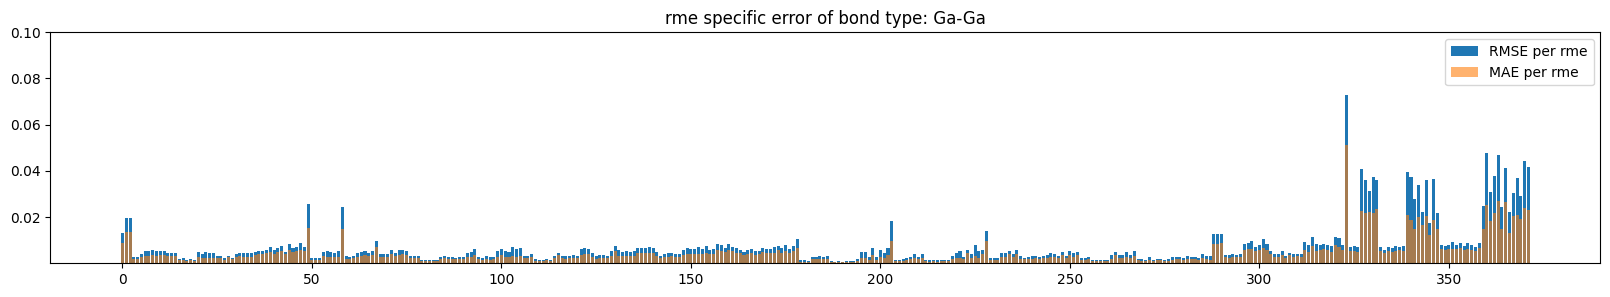

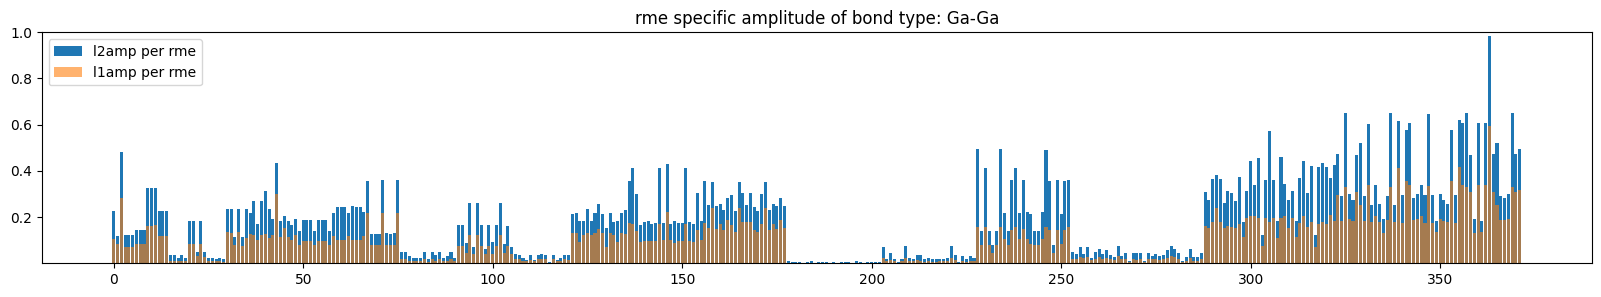

In [4]:
import torch
import matplotlib.pyplot as plt
from dptb.nn.hamiltonian import E3Hamiltonian

e3h = E3Hamiltonian(idp=model.idp, device=model.device, decompose=True)

mean = train_dataset[dN]["edge_features"].cuda().mean(dim=1, keepdim=True)
var = (train_dataset[dN]["edge_features"].cuda()-mean).norm(dim=1, keepdim=True) + 1e-5

mask = train_dataset.type_mapper.mask_to_erme[train_dataset[dN]["edge_type"].flatten()]

relative_mae_error = ((1/var) * (data["edge_features"]-mean) - (1/var) * (train_dataset[dN]["edge_features"].cuda()-mean)).abs()
relative_mae_error = torch.tensor([vec[ma].mean() for vec, ma in zip(relative_mae_error, mask)])
print("normalized MAE:", relative_mae_error.mean().data.item())

mae_error = (data["edge_features"] - train_dataset[dN]["edge_features"].cuda()).abs()
mae_error = torch.tensor([vec[ma].mean() for vec, ma in zip(mae_error, mask)])
print("absolute MAE:", mae_error.mean().data.item())

relative_rmse_error = ((1/var) * (data["edge_features"]-mean) - (1/var) * (train_dataset[dN]["edge_features"].cuda()-mean))**2
relative_rmse_error = torch.tensor([vec[ma].mean().sqrt() for vec, ma in zip(relative_rmse_error, mask)])
print("normalized RMSE:", relative_rmse_error.mean().data.item())

rmse_error = (data["edge_features"] - train_dataset[dN]["edge_features"].cuda())**2
rmse_error = torch.tensor([vec[ma].mean().sqrt() for vec, ma in zip(rmse_error, mask)])

print("absolute RMSE:", rmse_error.mean().data.item())

bondtype = data["edge_type"].reshape(-1).cpu()

for bt, tp in train_dataset.type_mapper.bond_to_type.items():
    rmserr = rmse_error[bondtype==tp].mean()
    maerr = mae_error[bondtype==tp].mean()
    print("rmse err for bond {bt}: {rmserr} \t mae err for bond {bt}: {maerr}".format(bt=bt, rmserr=rmserr, maerr=maerr))

# compute error for each rme for each bond type
err = e3h(data.copy())["edge_features"] - e3h(AtomicData.to_AtomicDataDict(train_dataset[dN].to(model.device)))["edge_features"]
amp = train_dataset[dN]["edge_features"].cuda()
for bt, tp in train_dataset.type_mapper.bond_to_type.items():
    bond_mask = mask[train_dataset[dN]["edge_type"].flatten().eq(tp)]
    bond_err = err[train_dataset[dN]["edge_type"].flatten().eq(tp)]
    bond_amp = amp[train_dataset[dN]["edge_type"].flatten().eq(tp)]
    bond_err = torch.stack([vec[ma] for vec, ma in zip(bond_err, bond_mask)])
    bond_amp = torch.stack([vec[ma] for vec, ma in zip(bond_amp, bond_mask)])
    rmserr = (bond_err**2).mean(dim=0).sqrt()
    maerr = bond_err.abs().mean(dim=0)
    l2amp = (bond_amp**2).mean(dim=0).sqrt()
    l1amp = bond_amp.abs().mean(dim=0)
    x = list(range(len(rmserr)))
    plt.figure(figsize=(20,3))
    plt.bar(x, rmserr.cpu().detach(), label="RMSE per rme")
    plt.bar(x, maerr.cpu().detach(), alpha=0.6, label="MAE per rme")
    plt.legend()
    # plt.yscale("log")
    plt.ylim([1e-5, 1e-1])
    plt.title("rme specific error of bond type: {bt}".format(bt=bt))
    plt.show()

    plt.figure(figsize=(20,3))
    plt.bar(x, l2amp.cpu().detach(), label="l2amp per rme")
    plt.bar(x, l1amp.cpu().detach(), alpha=0.6, label="l1amp per rme")
    plt.legend()
    # plt.yscale("log")
    plt.ylim([1e-5, 1e0])
    plt.title("rme specific amplitude of bond type: {bt}".format(bt=bt))
    plt.show()


# max_error = (data["edge_features"] - train_dataset[dN]["edge_features"].cuda()).abs()
# max_error = torch.tensor([vec[ma].max() for vec, ma in zip(max_error, mask)])

# x = list(range(len(rmse_error)))
# plt.figure(figsize=(20,3))
# plt.bar(x, relative_mae_error.cpu().detach(), label="rel MAE")
# plt.bar(x, mae_error.cpu().detach(), alpha=0.6, label="abs MAE")
# plt.legend()
# plt.yscale("log")
# plt.ylim([1e-4, 1e-1])
# plt.show()

# plt.figure(figsize=(20,3))
# plt.bar(x, relative_rmse_error.cpu().detach(), label="rel RMSE")
# plt.bar(x, rmse_error.cpu().detach(), alpha=0.6, label="abs RMSE")
# plt.legend()
# plt.yscale("log")
# plt.ylim([1e-4, 1e-1])
# plt.show()

# plt.figure(figsize=(20,3))
# plt.bar(x, mae_error.cpu().detach(), label="rmse error per block")
# plt.bar(x, rmse_error.cpu().detach(), alpha=0.6, label="rmse error per block")
# plt.legend()
# plt.yscale("log")
# plt.ylim([1e-4, 1e-1])
# plt.show()

{'onsite': {'N': {'rmse': tensor(0.0145, device='cuda:0', grad_fn=<SqrtBackward0>),
   'mae': tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>),
   'rmse_per_block_element': tensor([2.4469e-03, 1.5001e-02, 4.1928e-02, 4.3388e-04, 1.1365e-03, 2.4607e-03,
           7.7827e-04, 8.3090e-04, 3.7622e-04, 5.0764e-04, 4.6961e-04, 8.0742e-04,
           1.2278e-03, 1.2019e-03, 1.3381e-03, 1.4815e-03, 1.1291e-03, 2.7982e-04,
           7.8271e-04, 3.1200e-04, 1.0138e-03, 8.5672e-04, 9.7850e-05, 7.2672e-04,
           4.0923e-04, 9.9758e-03, 1.1561e-03, 2.1526e-03, 1.1545e-03, 9.4169e-03,
           5.9623e-04, 2.1537e-03, 5.9185e-04, 1.0417e-02, 1.4719e-02, 1.0372e-03,
           5.9560e-04, 9.3789e-04, 1.3416e-02, 4.6505e-04, 6.2618e-04, 5.8849e-04,
           1.4172e-02, 2.2936e-02, 7.6938e-04, 1.2389e-03, 7.7079e-04, 2.4090e-02,
           4.9139e-04, 1.2376e-03, 4.9087e-04, 2.3702e-02, 8.7009e-04, 6.0376e-04,
           4.0144e-04, 4.9756e-03, 2.9461e-04, 4.9149e-03, 8.9839e-04, 7.53

normalized MAE: 1.2490047083701938e-05
absolute MAE: 0.0018812386551871896
normalized RMSE: 3.3060314308386296e-05
absolute RMSE: 0.004961133934557438


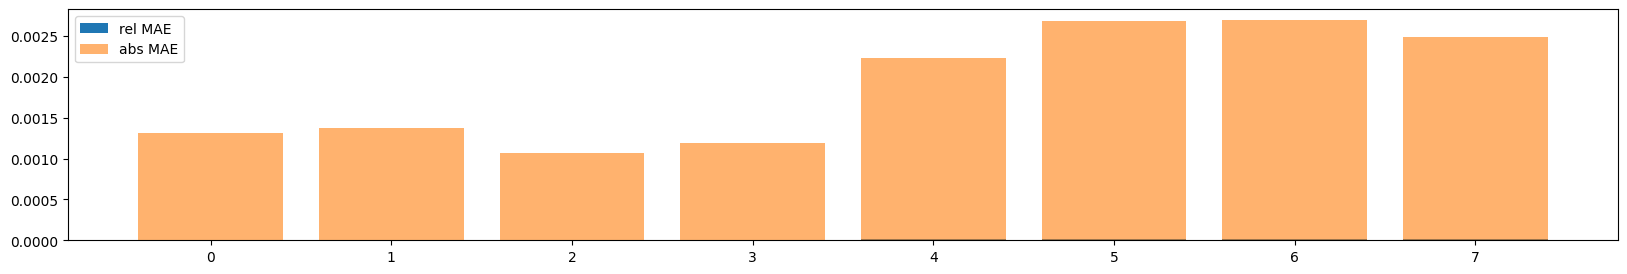

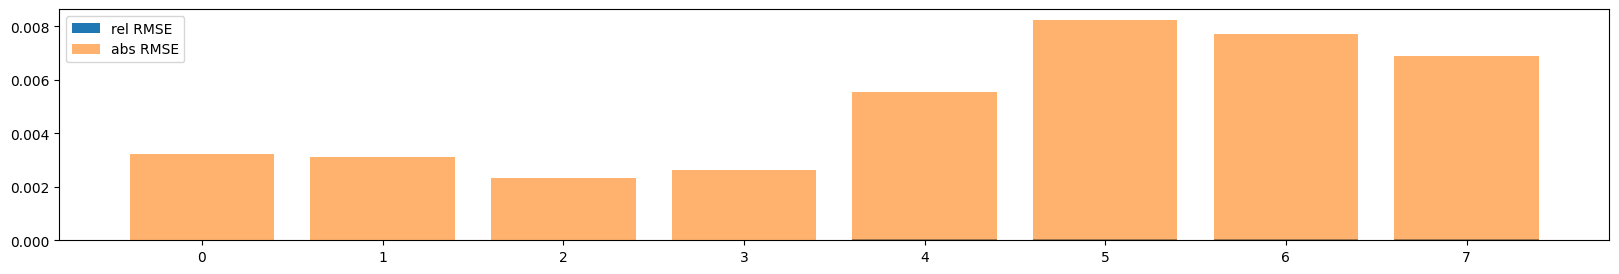

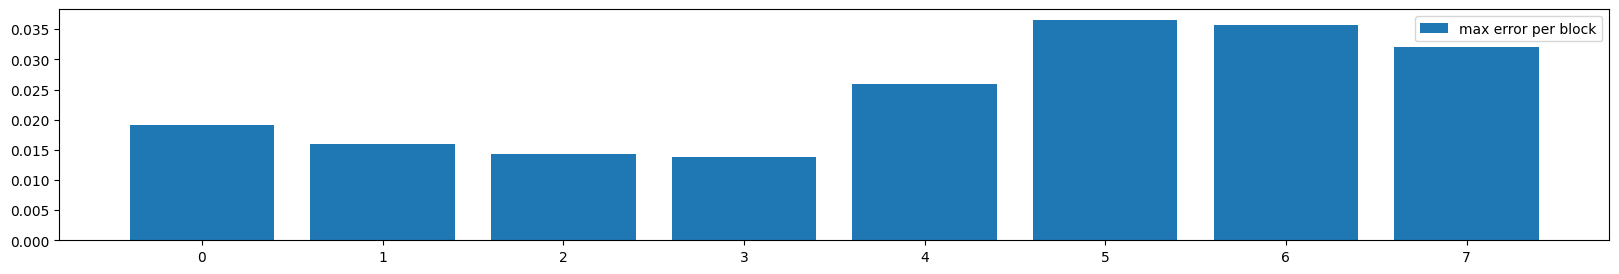

In [5]:
import torch
import matplotlib.pyplot as plt

dN = 100
mean = train_dataset[dN]["node_features"].cuda().mean(dim=1, keepdim=True)
var = (train_dataset[dN]["node_features"].cuda()-mean).norm(dim=1, keepdim=True) + 1e-5

mask = train_dataset.type_mapper.mask_to_nrme[train_dataset[dN]["atom_types"].flatten()]

relative_mae_error = ((1/var) * (data["node_features"]-mean) - (1/var) * (train_dataset[dN]["node_features"].cuda()-mean)).abs()
relative_mae_error = torch.tensor([vec[ma].mean() for vec, ma in zip(relative_mae_error, mask)])
print("normalized MAE:", relative_mae_error.mean().data.item())

mae_error = (data["node_features"] - train_dataset[dN]["node_features"].cuda()).abs()
mae_error = torch.tensor([vec[ma].mean() for vec, ma in zip(mae_error, mask)])
print("absolute MAE:", mae_error.mean().data.item())

relative_rmse_error = ((1/var) * (data["node_features"]-mean) - (1/var) * (train_dataset[dN]["node_features"].cuda()-mean))**2
relative_rmse_error = torch.tensor([vec[ma].mean().sqrt() for vec, ma in zip(relative_rmse_error, mask)])
print("normalized RMSE:", relative_rmse_error.mean().data.item())

rmse_error = (data["node_features"] - train_dataset[dN]["node_features"].cuda())**2
rmse_error = torch.tensor([vec[ma].mean().sqrt() for vec, ma in zip(rmse_error, mask)])
print("absolute RMSE:", rmse_error.mean().data.item())

max_error = (data["node_features"] - train_dataset[dN]["node_features"].cuda()).abs()
max_error = torch.tensor([vec[ma].max() for vec, ma in zip(max_error, mask)])

x = list(range(len(rmse_error)))
plt.figure(figsize=(20,3))
plt.bar(x, relative_mae_error.cpu().detach(), label="rel MAE")
plt.bar(x, mae_error.cpu().detach(), alpha=0.6, label="abs MAE")
plt.legend()
# plt.yscale("log")
plt.show()

plt.figure(figsize=(20,3))
plt.bar(x, relative_rmse_error.cpu().detach(), label="rel RMSE")
plt.bar(x, rmse_error.cpu().detach(), alpha=0.6, label="abs RMSE")
plt.legend()
# plt.yscale("log")
plt.show()

plt.figure(figsize=(20,3))
plt.bar(x, max_error.cpu().detach(), label="max error per block")
plt.legend()
plt.show()

In [57]:
import torch
print(torch.arange(0,len(data["edge_lengths"]))[data["edge_lengths"].cpu()<2.97])

tensor([  3,  20,  40,  53, 113, 114, 117, 119, 138, 140, 159, 161, 225, 231,
        258, 259, 264, 268, 284, 317, 331, 360, 361, 375, 405, 415, 417, 441,
        475, 497, 511, 512])


In [6]:
import matplotlib.pyplot as plt
from dptb.data.transforms import OrbitalMapper

fig = plt.figure(figsize=(20,3))

pair_irreps = model.idp.pair_irreps.simplify()
ir_index = pair_irreps.sort()[1]
idx = []
loc = 0
for ii in ir_index:
    idx += range(loc, loc+pair_irreps[ii].dim)
    loc += pair_irreps[ii].dim
print(pair_irreps.sort()[0].simplify())
N = 512
print(train_dataset[0]["edge_type"][N])
print(data["edge_lengths"][N])
mask = train_dataset.type_mapper.mask_to_erme[train_dataset[0]["edge_type"][N].flatten()].flatten()
x = list(range(len(data["edge_features"][N,:][idx][mask[[idx]]].detach().cpu().T)))
plt.bar(x, data["edge_features"][N,:][idx][mask[[idx]]].detach().cpu().T, label="pre")
plt.bar(x, train_dataset[0]["edge_features"][N,:][idx][mask[[idx]]].detach().T, alpha=0.6, ls="-.", label="lbl")
# plt.plot(data["edge_features"].detach().T, alpha=0.5, label="pre", c="tab:orange")
# plt.plot(train_dataset[0]["edge_features"][25,:].detach().T, ls="-.", alpha=0.7, label="target", c="tab:orange")
plt.legend()
# plt.ylim(-0.5,0.5)
plt.show()

fig = plt.figure(figsize=(20,3))
plt.bar(x, (data["edge_features"][N,:][idx][mask[[idx]]].detach().cpu().T-train_dataset[0]["edge_features"][N,:][idx][mask[[idx]]].detach().T).abs(), alpha=0.7, label="pre")
# plt.plot(data["edge_features"].detach().T, alpha=0.5, label="pre", c="tab:orange")
# plt.plot(train_dataset[0]["edge_features"][25,:].detach().T, ls="-.", alpha=0.7, label="target", c="tab:orange")
plt.legend()
# plt.ylim(-0.5,0.5)
plt.show()

# fig = plt.figure(figsize=(5,5))
# plt.scatter(data["edge_features"][:,:].detach().flatten(), train_dataset[0]["edge_features"][:,:].detach().flatten())
# plt.xlabel("pre")
# plt.ylabel("target")
# plt.show()

33x0e+40x1o+17x1e+8x2o+25x2e+8x3o+1x3e+1x4e
tensor([2])


IndexError: index 512 is out of bounds for dimension 0 with size 476

<Figure size 2000x300 with 0 Axes>

21x0e+20x1o+11x1e+4x2o+15x2e+4x3o+1x3e+1x4e
tensor([0])


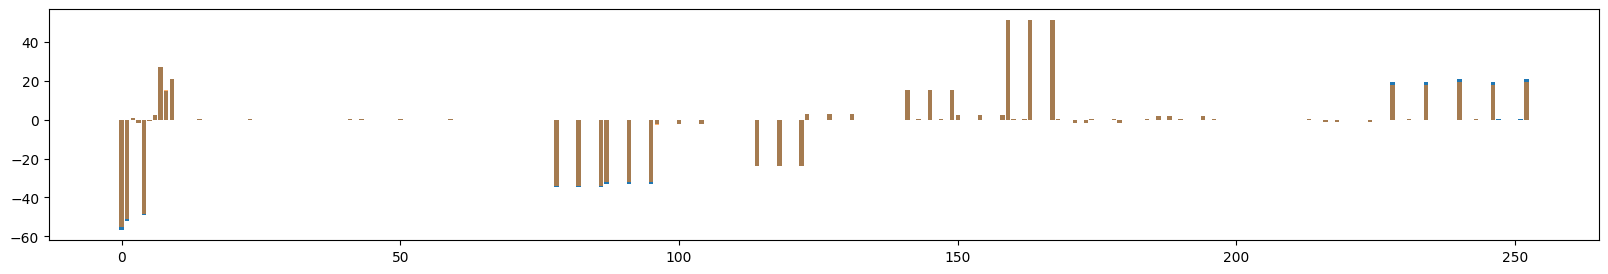

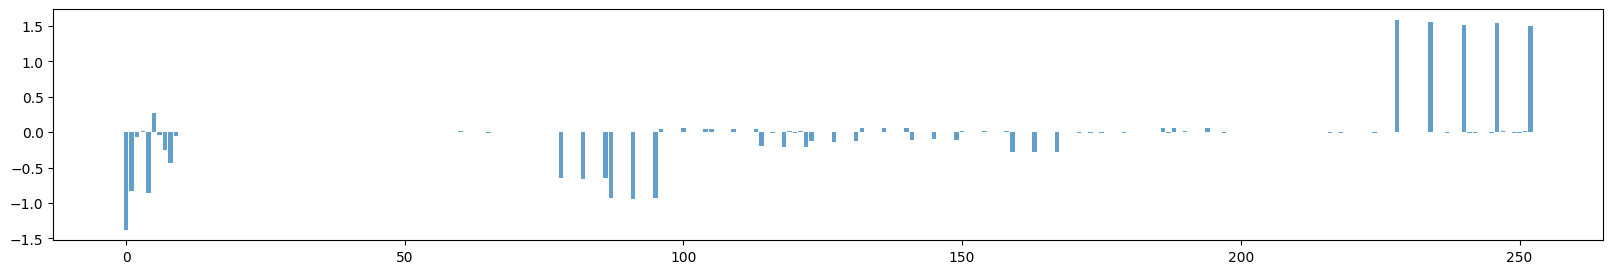

In [52]:
import matplotlib.pyplot as plt
from dptb.data.transforms import OrbitalMapper

fig = plt.figure(figsize=(20,3))

node_irreps = model.idp.node_irreps.simplify()
ir_index = node_irreps.sort()[1]
idx = []
loc = 0
for ii in ir_index:
    idx += range(loc, loc+node_irreps[ii].dim)
    loc += node_irreps[ii].dim
print(node_irreps.sort()[0].simplify())
N = 3
print(train_dataset[0]["atom_types"][N])
mask = train_dataset.type_mapper.mask_to_nrme[train_dataset[0]["atom_types"][N].flatten()].flatten()

x = list(range(len(data["node_features"][N,:][idx][mask[[idx]]].detach().cpu().T)))
plt.bar(x, data["node_features"][N,:][idx][mask[[idx]]].detach().cpu().T, label="pre")
plt.bar(x, train_dataset[0]["node_features"][N,:][idx][mask[[idx]]].detach().T, alpha=0.6, ls="-.", label="pre")
plt.show()

fig = plt.figure(figsize=(20,3))
plt.bar(x, data["node_features"][N,:][idx][mask[[idx]]].detach().cpu().T-train_dataset[0]["node_features"][N,:][idx][mask[[idx]]].detach().T, alpha=0.7, label="pre")
plt.show()


In [66]:
from dptb.nn.nnsk import NNSK
import json
from dptb.utils.tools import j_loader

from dptb.nn.hr2hk import HR2HK
from dptb.nn.energy import  Eigenvalues
from dptb.data import AtomicData, AtomicDataDict, ABACUSDataset
from dptb.data.transforms import OrbitalMapper
from ase.io import read, write
import matplotlib.pyplot as plt

atoms = train_dataset[2].to_ase()

import numpy as np
from dptb.utils.make_kpoints import abacus_kpath

kpts = np.array([[0.0000000000,   0.0000000000,   0.0000000000,   30],   
                 [0.5000000000,   0.0000000000,   0.5000000000,   30],               
                 [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                 [0.3750000000,   0.3750000000,   0.7500000000,   30],     
                 [0.0000000000,   0.0000000000,   0.0000000000,   30],    
                 [0.5000000000,   0.5000000000,   0.5000000000,   30],                
                 [0.5000000000,   0.2500000000,   0.7500000000,   30],               
                 [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                 ])
kpoints, xlist, hsp = abacus_kpath(atoms, kpts)

import torch

data = train_dataset[0].to_AtomicDataDict(train_dataset[0].to(common_options["device"]))
data["kpoint"] = torch.from_numpy(kpoints).float().to(common_options["device"])

eigv = Eigenvalues(
    idp=model.idp,
    s_edge_field=AtomicDataDict.EDGE_OVERLAP_KEY,
    s_node_field=AtomicDataDict.NODE_OVERLAP_KEY,
    s_out_field=AtomicDataDict.OVERLAP_KEY,
    device=common_options["device"]
    )

model.eval()

data_predict = model(data.copy()).copy() # edge field is rme

# err = (eigv.h2k(data_predict.copy())["hamiltonian"]-eigv.h2k(data.copy())["hamiltonian"]).abs()
# plt.hist(err.flatten().detach().cpu(), bins=100, log=True)
# # plt.xscale("log")
# plt.show()

/opt/miniconda/envs/deeptb/lib/python3.8/site-packages/dptb/data/AtomicData.py:607: UserWarning: AtomicData.to_ase(): self didn't contain atomic numbers... using atom_type as atomic numbers instead, but this means the chemical symbols in ASE (outputs) will be wrong
  warnings.warn(


In [67]:
data = eigv(data).copy()
data_predict["edge_overlap"] = data["edge_overlap"]
data_predict = eigv(data_predict)

: 

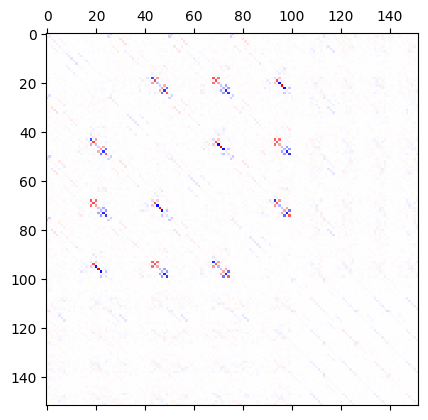

In [10]:
import matplotlib.pyplot as plt

plt.matshow((data_predict["hamiltonian"][0] - data["hamiltonian"][0]).real.detach().cpu(), cmap="bwr", vmax=1.0, vmin=-1.0)
plt.show()

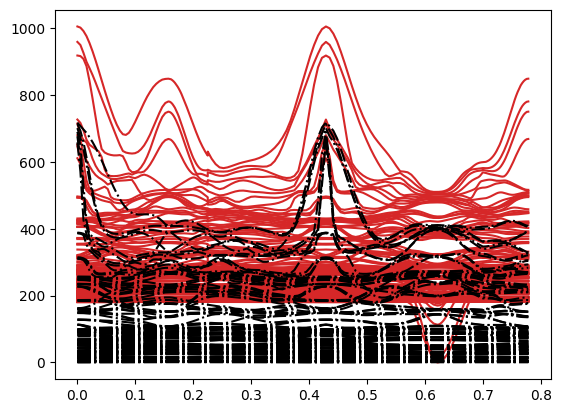

In [ ]:
import matplotlib.pyplot as plt

plt.plot(xlist, data_predict["eigenvalue"].detach().cpu()-data_predict["eigenvalue"].detach().min().cpu(), c="tab:red")
plt.plot(xlist, data["eigenvalue"].detach().cpu()-data["eigenvalue"].detach().min().cpu(), "-.", c="black")
plt.ylim(0,50)
plt.show()

In [1]:
from e3nn.o3 import Irreps

In [2]:
ir = Irreps("1e")

In [42]:
import e3nn.o3 as o3
from e3nn.o3 import SphericalHarmonics

lmax = 4
irreps_sh=o3.Irreps([(1, (i, (-1) ** i)) for i in range(lmax + 1)])
sh = SphericalHarmonics(
            irreps_sh, True, "component"
        )

In [43]:
import torch

a = torch.randn(1,3)
sh(a), sh(-a)

(tensor([[ 1.0000,  0.3583,  1.2061, -1.1903, -0.5506,  0.5579,  0.5084, -1.8535,
           0.8317,  0.5945, -1.0144,  0.4774, -0.5301, -1.5862,  1.5324, -0.4944,
          -0.5418,  1.2420, -1.1417,  0.1348, -1.2440, -0.4477,  1.7247, -1.0328,
           0.2299]]),
 tensor([[ 1.0000, -0.3583, -1.2061,  1.1903, -0.5506,  0.5579,  0.5084, -1.8535,
           0.8317, -0.5945,  1.0144, -0.4774,  0.5301,  1.5862, -1.5324,  0.4944,
          -0.5418,  1.2420, -1.1417,  0.1348, -1.2440, -0.4477,  1.7247, -1.0328,
           0.2299]]))